# Graph-UNets

Hereafter is the implementation of the paper https://arxiv.org/pdf/1905.05178v1.pdf, this is indeed the method chosen from the ones listed in the survey paper https://arxiv.org/pdf/2110.05292.pdf

To summarize the approach we composed a UNet, with its characteristical skip connections, after which we simply inserted a linear layer. Such topping allowed us to adoperate a method widely adopted for generation tasks to exploit it for graph classification.

In this experiment we fetched the most performing combination of method and parameters, GeneralConv with single-head dot-product attention, and added self-made residual connections.  
Residual connections are often adoperated in very deep neural networks, and in particular within UNets.

## Imports

In [1]:
import torch
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from tqdm import tqdm
from torch import nn
from torch_geometric.nn import GCNConv,TopKPooling,global_mean_pool, GraphConv, GeneralConv
from torch_geometric import seed_everything
from torch_geometric.utils.convert import to_scipy_sparse_matrix
from torch_geometric.utils.sparse import dense_to_sparse,to_torch_coo_tensor
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt

C:\Users\Lorenzo\PycharmProjects\NeuralNetworks\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset

For our experiment we picked the PROTEINS dataset, which is one of those selected in the Graph-UNets paper.  
The dataset was divided as such:
- 81% for the training set
- 9% for the validation set
- 10 % for the test set

In [2]:
seed_everything(77) #Seed for all random actions, this library is a proxy for other libraries, e.g. pytorch
path=""
dataset = TUDataset(path, name='PROTEINS').shuffle() #Here we shuffle the dataset to break any potential order correlation

print("Dataset is undirected? ", dataset[0].is_undirected()) #This is a vital information!
print ("Len of dataset: ", len(dataset))
train_set = dataset[:int(0.9*len(dataset))]
train_dataset = train_set[:int(0.9*len(train_set))]
val_dataset = train_set[int(0.9*len(train_set)):]
test_dataset = dataset[int(0.9*len(dataset)):]
print("Len of train dataset: ", len(train_dataset))
print("Len of validation dataset: ",len(val_dataset))
print("Len of test dataset: ",len(test_dataset))

batch_size=128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Dataset is undirected?  True
Len of dataset:  1113
Len of train dataset:  900
Len of validation dataset:  101
Len of test dataset:  112


## Graph Pooling

![title](graphpool.png)

In [3]:
class gPool(nn.Module):
    """
    Our implementation of the pooling methodology described in the paper, above you can see the pseudocode
    """
    def __init__(self,in_dim,ratio):
        super().__init__()
        self.in_dim=in_dim
        self.ratio=ratio
        self.p=nn.Linear(in_dim,1)
        self.sigmoid=nn.Sigmoid()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    def forward(self,xl,edge_index):
        
        #y is described as a learnable projection, hence we estimated a linear layer to be a suitable choice
        
        y=self.p(xl) #/torch.norm(self.p(xl)) #DO WE HAVE TO INSERT THE NORM?
        
        k=int(self.ratio*len(y))#Number of selected nodes, the k in TopkPooling
        
        topks, idx =torch.topk(y,k,dim=0) #The k elements with top scores, and their corresponding idx
        
        y_hat=self.sigmoid(topks)
        xl_hat=xl[idx,:].squeeze() #Feature matrix of topk nodes
        xl1=xl_hat * y_hat  #Gate operation
        
        al = torch.as_tensor(to_scipy_sparse_matrix(edge_index,num_nodes=len(y)).todense(), device = self.device)
        al1 = torch.index_select(torch.as_tensor(al),0,idx.squeeze()) #no direct indexing because of ram overloading
        al1=torch.index_select(al1,1,idx.squeeze())
        sparsel1=dense_to_sparse(al1)
        edge_index_pooled=torch.sparse_coo_tensor(sparsel1[0],sparsel1[1]).coalesce().indices() #Our model elaborates coo tensors
        return xl1, edge_index_pooled, idx.squeeze()

In [4]:
"""
Simple example to prove that dim=0 in the norm is not equal for all inputs, depends on the dimension
p=nn.Linear(4,1)
xl=torch.ones((6,4))
y=p(xl)/torch.norm(p(xl))
xl2=torch.ones((2,4))
print(torch.norm(p(xl),dim=0))
print(torch.norm(p(xl2),dim=0))
"""

'\nSimple example to prove that dim=0 in the norm is not equal for all inputs, depends on the dimension\np=nn.Linear(4,1)\nxl=torch.ones((6,4))\ny=p(xl)/torch.norm(p(xl))\nxl2=torch.ones((2,4))\nprint(torch.norm(p(xl),dim=0))\nprint(torch.norm(p(xl2),dim=0))\n'

## Graph Unpooling

In [4]:
class gUnpool(nn.Module):
    """
    Our implementation of the unpooling methodology described in the paper
    """
    def __init__(self,in_dim,out_dim):
        super().__init__()
        self.in_dim=in_dim
        self.out_dim=out_dim
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    def forward(self,xl,idx,up_shape):
        up_nodes,C = up_shape #We extract the number of nodes and features the graph has to return to
        xl1=torch.zeros((up_nodes,xl.shape[1]), device = self.device)
        xl1[idx]=xl #We fetch the current feature matrix and sorround it of zeros to have the desired shape
        return xl1
        

## U-Net

The U-Net as described in the paper, below is the graphical representation in the paper, however the number of up and down blocks is inferior with respect to the paper description, which is four upblocks and four downblocks as presented in the code below.

![title](unet_structure.png)

In [5]:
class UNet(nn.Module):
    def __init__(self, improved = False, dropout = 0.3 ):
        super().__init__()
        self.in_conv = GeneralConv(dataset.num_features, 16, directed_msg = False,attention= True, attention_type= 'dot_product')
        #heads = 4, 
        #attention= False
        #l2_normalize= False,
        #GraphConv(dataset.num_features, 16)
        
        self.GC1 =GeneralConv(16, 32, directed_msg = False,attention= True, attention_type= 'dot_product')
        self.GC2 =GeneralConv(32, 64,  directed_msg = False,attention= True, attention_type= 'dot_product')
        self.GC3 =GeneralConv(64, 128,  directed_msg = False,attention= True, attention_type= 'dot_product')
        self.GC4 =GeneralConv(128, 256,   directed_msg = False,attention= True, attention_type= 'dot_product')
        
        self.GCx3 = GeneralConv(32, 32, directed_msg = False, attention= True, attention_type= 'dot_product')
        self.GCx5 = GeneralConv(64, 64, directed_msg = False, attention= True, attention_type= 'dot_product')
        self.GCx7 = GeneralConv(128, 128, directed_msg = False, attention= True, attention_type= 'dot_product')
        self.GCx9 = GeneralConv(256, 256, directed_msg = False, attention= True, attention_type= 'dot_product')
        
        self.act=nn.ELU()
        
        self.gPool1 = gPool(16, 0.9)
        self.gPool2 = gPool(32, 0.7)
        self.gPool3 = gPool(64, 0.6)
        self.gPool4 = gPool(128, 0.5)
        
        self.gUnpool1 = gUnpool(256, 128)
        self.gUnpool2 = gUnpool(128, 64)
        self.gUnpool3 = gUnpool(64, 32)
        self.gUnpool4 = gUnpool(32, 16)
        
        self.GC5 = GeneralConv(256+128, 128, directed_msg = False, attention= True, attention_type= 'dot_product')
        self.GC6 = GeneralConv(128+64, 64, directed_msg = False, attention= True,  attention_type= 'dot_product')
        self.GC7 = GeneralConv(64+32, 32, directed_msg = False, attention= True,  attention_type= 'dot_product')
        self.GC8 = GeneralConv(32+16, 16, directed_msg = False, attention= True, attention_type= 'dot_product')
        
        self.GCx11 = GeneralConv(128, 128, directed_msg = False, attention= True, attention_type= 'dot_product')
        self.GCx13 = GeneralConv(64, 64, directed_msg = False, attention= True, attention_type= 'dot_product')
        self.GCx15 = GeneralConv(32, 32, directed_msg = False, attention= True, attention_type= 'dot_product')
        self.GCx17 = GeneralConv(16, 16, directed_msg = False, attention= True, attention_type= 'dot_product')
        
        self.out_conv = GeneralConv(16, dataset.num_features, directed_msg = False, attention= True, attention_type= 'dot_product')
        
        self.linear = nn.Linear(dataset.num_features, 1)
        
    
    def forward(self,x,edge_index,batch):
        x1 = self.in_conv(x, edge_index)
        x1 = self.act(x1) 
        
        # Encoder
        
        #Pool1
        #x2,edge_index2,_,batch2,_,_ = self.gPool1(x1, edge_index)
        x2, edge_index2, idx2 = self.gPool1(x1,edge_index)
        x2 = self.act(x2)
        
        x3 = self.GC1(x2, edge_index2) #32
        x3 = self.act(x3 + self.GCx3(x3, edge_index2)) 
        
        #Pool2
        #x4,edge_index4,_,batch4,_,_ = self.gPool2(x3, edge_index2)
        x4,  edge_index4, idx4 = self.gPool2(x3,edge_index2)
        x4 = self.act(x4)
        
        x5 = self.GC2(x4, edge_index4)
        x5 = self.act(x5 + self.GCx5(x5, edge_index4))
        
        #Pool3
        #x6,edge_index6,_,batch6,_,_ = self.gPool3(x5, edge_index4)
        x6,  edge_index6, idx6 = self.gPool3(x5,edge_index4)
        x6 = self.act(x6)
        
        x7 = self.GC3(x6, edge_index6)
        x7 = self.act(x7 + self.GCx7(x7, edge_index6))
        
        #Pool4
        #x8,edge_index8,_,batch8,_,_ = self.gPool4(x7, edge_index6)
        x8,  edge_index8, idx8 = self.gPool4(x7,edge_index6)
        x8 = self.act(x8)
        
        x9 = self.GC4(x8, edge_index8)
        x9 = self.act(x9 + self.GCx9(x9, edge_index8))
        
        #Decoder
        
        #Unpool1
        x10 = self.gUnpool1(x9,idx8,x7.shape)
        x10 = torch.cat([x7, x10], dim=1)
        #x10 = x7 + x10
        x10 = self.act(x10)
        
        x11 = self.GC5(x10, edge_index8)
        x11 = self.act(x11 + self.GCx11(x11,edge_index8 ))
        
        #Unpool2
        x12 = self.gUnpool2(x11,idx6,x5.shape)
        x12 = torch.cat([x5, x12], dim=1)
        x12 = self.act(x12)
        
        x13 = self.GC6(x12, edge_index6)
        x13 = self.act(x13 + self.GCx13(x13, edge_index6 ))
        
        #Unpool3
        x14 = self.gUnpool3(x13,idx4,x3.shape)
        x14 = torch.cat([x3, x14], dim=1)
        x14 = self.act(x14)
        
        x15 = self.GC7(x14, edge_index4)
        x15 = self.act(x15 + self.GCx15(x15, edge_index4 ))
        
        #Unpool4
        x16 = self.gUnpool4(x15,idx2,x1.shape)
        x16 = torch.cat([x1, x16], dim=1)
        x16 = self.act(x16)
        
        x17 = self.GC8(x16, edge_index2)
        x17 = self.act(x17 + self.GCx17(x17, edge_index2 ))
        
        
        x18 = self.out_conv(x17, edge_index)
        x18 = self.act(x18)
        
        #Readout
        x19 = global_mean_pool(x18, batch) #readout layer commonly adoperated - reference: https://colab.research.google.com/drive/1I8a0DfQ3fI7Njc62__mVXUlcAleUclnb?usp=sharing#scrollTo=CN3sRVuaQ88l
        x19 = self.act(x19)
        
        #Linear
        x19=self.linear(x19)
        
        return x19

## Parameters customization

In [6]:
seed_everything(77)
lrate =0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=UNet().to(device) #Customize the model by changing these parameters

optimizer = torch.optim.Adam(model.parameters(), lr=lrate) #Adam because it is adaptive
criterion=nn.BCEWithLogitsLoss()
sigmoid=nn.Sigmoid()
epochs=200

## Training

Here we start the training of the model, we perform one epoch on the training set and one on the validation set.

In [7]:
seed_everything(77)
train_losses=[]
val_losses=[]
train_accuracies=[]
val_accuracies=[]
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    train_acc=0.0
    for i, data in enumerate(tqdm(train_loader)):
        data = data.to(device) #E.g. DataBatch(edge_index=[2, 19062], x=[5024, 3], y=[128], batch=[5024], ptr=[129])
        optimizer.zero_grad()
        pred = model(data.x, data.edge_index, data.batch)
        loss = criterion(pred.squeeze(), data.y.type(torch.float))
        loss.backward()
        probs=sigmoid(pred.squeeze())
        acc=accuracy_score(data.y.cpu(),torch.round(probs).detach().cpu())
        train_acc+=acc
        train_loss += loss.item()
        optimizer.step()
        
    epoch_train_loss=train_loss/len(train_loader) #We compute the average train loss for each epoch
    train_losses.append(epoch_train_loss)
    epoch_train_accuracy=train_acc/len(train_loader) #We compute the average train accuracy for each epoch
    train_accuracies.append(epoch_train_accuracy)
    print(f"Training loss epoch {epoch}: ", epoch_train_loss)
    print(f"Training accuracy epoch {epoch}: ", epoch_train_accuracy)
    
    model.eval()
    val_loss = 0.0
    val_acc=0.0
    for i, data in enumerate(tqdm(val_loader)):
        data = data.to(device)
        pred = model(data.x, data.edge_index, data.batch)
        loss = criterion(pred.squeeze(), data.y.type(torch.float))
        probs=sigmoid(pred.squeeze())
        acc=accuracy_score(data.y.cpu(),torch.round(probs).detach().cpu())
        val_acc+=acc
        val_loss += loss.item()
    
    epoch_val_loss=val_loss/len(val_loader) #We compute the average train loss for each epoch
    val_losses.append(epoch_val_loss)
    epoch_val_accuracy=val_acc/len(val_loader) #We compute the average train accuracy for each epoch
    val_accuracies.append(epoch_val_accuracy)
    print(f"Validation loss epoch {epoch}: ", epoch_val_loss)
    print(f"Validation accuracy epoch {epoch}: ", epoch_val_accuracy)
print('Finished Training')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.60it/s]


Training loss epoch 0:  0.6751565486192703
Training accuracy epoch 0:  0.6123046875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]


Validation loss epoch 0:  0.6690092086791992
Validation accuracy epoch 0:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.65it/s]


Training loss epoch 1:  0.6861750856041908
Training accuracy epoch 1:  0.5830078125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.32it/s]


Validation loss epoch 1:  0.6660119295120239
Validation accuracy epoch 1:  0.6237623762376238


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.67it/s]


Training loss epoch 2:  0.6522359773516655
Training accuracy epoch 2:  0.66796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]


Validation loss epoch 2:  0.6658536791801453
Validation accuracy epoch 2:  0.6039603960396039


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.80it/s]


Training loss epoch 3:  0.6261874362826347
Training accuracy epoch 3:  0.673828125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.34it/s]


Validation loss epoch 3:  0.6605270504951477
Validation accuracy epoch 3:  0.6039603960396039


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.81it/s]


Training loss epoch 4:  0.6683810502290726
Training accuracy epoch 4:  0.6103515625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.50it/s]


Validation loss epoch 4:  0.6452720761299133
Validation accuracy epoch 4:  0.6336633663366337


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.86it/s]


Training loss epoch 5:  0.6468465998768806
Training accuracy epoch 5:  0.6533203125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.14it/s]


Validation loss epoch 5:  0.6444578170776367
Validation accuracy epoch 5:  0.6336633663366337


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.89it/s]


Training loss epoch 6:  0.6610019207000732
Training accuracy epoch 6:  0.6171875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.31it/s]


Validation loss epoch 6:  0.6449428796768188
Validation accuracy epoch 6:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.80it/s]


Training loss epoch 7:  0.6492067202925682
Training accuracy epoch 7:  0.65234375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.72it/s]


Validation loss epoch 7:  0.6322321891784668
Validation accuracy epoch 7:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.75it/s]


Training loss epoch 8:  0.6448584198951721
Training accuracy epoch 8:  0.66796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.51it/s]


Validation loss epoch 8:  0.6890231370925903
Validation accuracy epoch 8:  0.594059405940594


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.79it/s]


Training loss epoch 9:  0.7140420973300934
Training accuracy epoch 9:  0.5625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]


Validation loss epoch 9:  0.6906298398971558
Validation accuracy epoch 9:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.78it/s]


Training loss epoch 10:  0.6464818492531776
Training accuracy epoch 10:  0.671875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.28it/s]


Validation loss epoch 10:  0.6703555583953857
Validation accuracy epoch 10:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.79it/s]


Training loss epoch 11:  0.6342025250196457
Training accuracy epoch 11:  0.6552734375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.13it/s]


Validation loss epoch 11:  0.6915072202682495
Validation accuracy epoch 11:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.73it/s]


Training loss epoch 12:  0.6784406825900078
Training accuracy epoch 12:  0.591796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.72it/s]


Validation loss epoch 12:  0.670201301574707
Validation accuracy epoch 12:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.50it/s]


Training loss epoch 13:  0.6729293242096901
Training accuracy epoch 13:  0.5751953125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]


Validation loss epoch 13:  0.6634767055511475
Validation accuracy epoch 13:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.57it/s]


Training loss epoch 14:  0.6340194866061211
Training accuracy epoch 14:  0.66796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.81it/s]


Validation loss epoch 14:  0.6710355281829834
Validation accuracy epoch 14:  0.5643564356435643


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.47it/s]


Training loss epoch 15:  0.6656407490372658
Training accuracy epoch 15:  0.5927734375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.82it/s]


Validation loss epoch 15:  0.6670148968696594
Validation accuracy epoch 15:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.47it/s]


Training loss epoch 16:  0.6366038545966148
Training accuracy epoch 16:  0.701171875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.82it/s]


Validation loss epoch 16:  0.6652585864067078
Validation accuracy epoch 16:  0.6138613861386139


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.45it/s]


Training loss epoch 17:  0.662183940410614
Training accuracy epoch 17:  0.6259765625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.70it/s]


Validation loss epoch 17:  0.6551886200904846
Validation accuracy epoch 17:  0.6435643564356436


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.45it/s]


Training loss epoch 18:  0.6438378617167473
Training accuracy epoch 18:  0.63671875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.67it/s]


Validation loss epoch 18:  0.6574538350105286
Validation accuracy epoch 18:  0.6237623762376238


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.47it/s]


Training loss epoch 19:  0.6517841815948486
Training accuracy epoch 19:  0.6201171875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]


Validation loss epoch 19:  0.654773473739624
Validation accuracy epoch 19:  0.6336633663366337


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.46it/s]


Training loss epoch 20:  0.6640884578227997
Training accuracy epoch 20:  0.6220703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.67it/s]


Validation loss epoch 20:  0.6360465288162231
Validation accuracy epoch 20:  0.6138613861386139


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.47it/s]


Training loss epoch 21:  0.6760044544935226
Training accuracy epoch 21:  0.5859375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.55it/s]


Validation loss epoch 21:  0.6516116857528687
Validation accuracy epoch 21:  0.6336633663366337


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.43it/s]


Training loss epoch 22:  0.6334220767021179
Training accuracy epoch 22:  0.6953125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.70it/s]


Validation loss epoch 22:  0.661835789680481
Validation accuracy epoch 22:  0.6039603960396039


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.44it/s]


Training loss epoch 23:  0.653194896876812
Training accuracy epoch 23:  0.62890625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


Validation loss epoch 23:  0.665440022945404
Validation accuracy epoch 23:  0.6039603960396039


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.53it/s]


Training loss epoch 24:  0.6468995660543442
Training accuracy epoch 24:  0.658203125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.13it/s]


Validation loss epoch 24:  0.6556504964828491
Validation accuracy epoch 24:  0.6336633663366337


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.55it/s]


Training loss epoch 25:  0.6721955388784409
Training accuracy epoch 25:  0.61328125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


Validation loss epoch 25:  0.656926691532135
Validation accuracy epoch 25:  0.6435643564356436


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:06<00:00,  1.32it/s]


Training loss epoch 26:  0.6728736981749535
Training accuracy epoch 26:  0.609375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.57it/s]


Validation loss epoch 26:  0.6571660041809082
Validation accuracy epoch 26:  0.6138613861386139


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.37it/s]


Training loss epoch 27:  0.667779766023159
Training accuracy epoch 27:  0.642578125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.55it/s]


Validation loss epoch 27:  0.657121479511261
Validation accuracy epoch 27:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.36it/s]


Training loss epoch 28:  0.639356717467308
Training accuracy epoch 28:  0.671875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.81it/s]


Validation loss epoch 28:  0.6496509313583374
Validation accuracy epoch 28:  0.6435643564356436


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.38it/s]


Training loss epoch 29:  0.6404879838228226
Training accuracy epoch 29:  0.669921875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.67it/s]


Validation loss epoch 29:  0.6502413749694824
Validation accuracy epoch 29:  0.6435643564356436


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.35it/s]


Training loss epoch 30:  0.6512739062309265
Training accuracy epoch 30:  0.646484375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]


Validation loss epoch 30:  0.6392347812652588
Validation accuracy epoch 30:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.41it/s]


Training loss epoch 31:  0.6416914388537407
Training accuracy epoch 31:  0.6640625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]


Validation loss epoch 31:  0.644693911075592
Validation accuracy epoch 31:  0.6336633663366337


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.55it/s]


Training loss epoch 32:  0.6548788025975227
Training accuracy epoch 32:  0.6591796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.68it/s]


Validation loss epoch 32:  0.6620527505874634
Validation accuracy epoch 32:  0.6138613861386139


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.51it/s]


Training loss epoch 33:  0.6568745002150536
Training accuracy epoch 33:  0.638671875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.67it/s]


Validation loss epoch 33:  0.6661777496337891
Validation accuracy epoch 33:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.49it/s]


Training loss epoch 34:  0.6522893160581589
Training accuracy epoch 34:  0.62109375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


Validation loss epoch 34:  0.676409900188446
Validation accuracy epoch 34:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.51it/s]


Training loss epoch 35:  0.6484541371464729
Training accuracy epoch 35:  0.630859375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


Validation loss epoch 35:  0.6596481204032898
Validation accuracy epoch 35:  0.6237623762376238


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.53it/s]


Training loss epoch 36:  0.646888017654419
Training accuracy epoch 36:  0.67578125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]


Validation loss epoch 36:  0.6575698256492615
Validation accuracy epoch 36:  0.6435643564356436


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.53it/s]


Training loss epoch 37:  0.6442908346652985
Training accuracy epoch 37:  0.6640625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.82it/s]


Validation loss epoch 37:  0.6564611792564392
Validation accuracy epoch 37:  0.6336633663366337


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.50it/s]


Training loss epoch 38:  0.6230986788868904
Training accuracy epoch 38:  0.6982421875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]


Validation loss epoch 38:  0.6441830992698669
Validation accuracy epoch 38:  0.693069306930693


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.48it/s]


Training loss epoch 39:  0.6237048432230949
Training accuracy epoch 39:  0.7001953125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.81it/s]


Validation loss epoch 39:  0.6634164452552795
Validation accuracy epoch 39:  0.6336633663366337


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.52it/s]


Training loss epoch 40:  0.6615624949336052
Training accuracy epoch 40:  0.6240234375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.78it/s]


Validation loss epoch 40:  0.6624424457550049
Validation accuracy epoch 40:  0.594059405940594


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.51it/s]


Training loss epoch 41:  0.6387944146990776
Training accuracy epoch 41:  0.642578125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]


Validation loss epoch 41:  0.6574296951293945
Validation accuracy epoch 41:  0.6138613861386139


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.48it/s]


Training loss epoch 42:  0.6671069338917732
Training accuracy epoch 42:  0.6357421875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]


Validation loss epoch 42:  0.6467927098274231
Validation accuracy epoch 42:  0.6435643564356436


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.47it/s]


Training loss epoch 43:  0.6410355642437935
Training accuracy epoch 43:  0.6689453125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.67it/s]


Validation loss epoch 43:  0.6632687449455261
Validation accuracy epoch 43:  0.6039603960396039


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.51it/s]


Training loss epoch 44:  0.6530598625540733
Training accuracy epoch 44:  0.6318359375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.81it/s]


Validation loss epoch 44:  0.6746702194213867
Validation accuracy epoch 44:  0.6039603960396039


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.50it/s]


Training loss epoch 45:  0.6868071630597115
Training accuracy epoch 45:  0.5927734375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.70it/s]


Validation loss epoch 45:  0.6875932216644287
Validation accuracy epoch 45:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.49it/s]


Training loss epoch 46:  0.658770278096199
Training accuracy epoch 46:  0.619140625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.67it/s]


Validation loss epoch 46:  0.6739923357963562
Validation accuracy epoch 46:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.53it/s]


Training loss epoch 47:  0.6467441245913506
Training accuracy epoch 47:  0.6298828125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


Validation loss epoch 47:  0.6552006006240845
Validation accuracy epoch 47:  0.594059405940594


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.49it/s]


Training loss epoch 48:  0.6324719563126564
Training accuracy epoch 48:  0.6572265625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.82it/s]


Validation loss epoch 48:  0.6476408839225769
Validation accuracy epoch 48:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.49it/s]


Training loss epoch 49:  0.6531727164983749
Training accuracy epoch 49:  0.6611328125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.42it/s]


Validation loss epoch 49:  0.6543980240821838
Validation accuracy epoch 49:  0.6237623762376238


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.46it/s]


Training loss epoch 50:  0.677134208381176
Training accuracy epoch 50:  0.5849609375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.84it/s]


Validation loss epoch 50:  0.6588899493217468
Validation accuracy epoch 50:  0.594059405940594


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.45it/s]


Training loss epoch 51:  0.6178002506494522
Training accuracy epoch 51:  0.6875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]


Validation loss epoch 51:  0.6451079249382019
Validation accuracy epoch 51:  0.6237623762376238


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.44it/s]


Training loss epoch 52:  0.6450728252530098
Training accuracy epoch 52:  0.6669921875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


Validation loss epoch 52:  0.6297903656959534
Validation accuracy epoch 52:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.44it/s]


Training loss epoch 53:  0.6359189823269844
Training accuracy epoch 53:  0.689453125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]


Validation loss epoch 53:  0.664826512336731
Validation accuracy epoch 53:  0.6138613861386139


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.46it/s]


Training loss epoch 54:  0.625800222158432
Training accuracy epoch 54:  0.673828125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.84it/s]


Validation loss epoch 54:  0.6734116673469543
Validation accuracy epoch 54:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.50it/s]


Training loss epoch 55:  0.6699987798929214
Training accuracy epoch 55:  0.599609375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.81it/s]


Validation loss epoch 55:  0.6658304929733276
Validation accuracy epoch 55:  0.6039603960396039


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.48it/s]


Training loss epoch 56:  0.6738376393914223
Training accuracy epoch 56:  0.626953125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.91it/s]


Validation loss epoch 56:  0.657414436340332
Validation accuracy epoch 56:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.50it/s]


Training loss epoch 57:  0.6716119349002838
Training accuracy epoch 57:  0.6064453125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Validation loss epoch 57:  0.6606094241142273
Validation accuracy epoch 57:  0.6435643564356436


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.44it/s]


Training loss epoch 58:  0.6501357555389404
Training accuracy epoch 58:  0.6259765625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.68it/s]


Validation loss epoch 58:  0.6462342143058777
Validation accuracy epoch 58:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.36it/s]


Training loss epoch 59:  0.6339181587100029
Training accuracy epoch 59:  0.685546875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Validation loss epoch 59:  0.6677588820457458
Validation accuracy epoch 59:  0.594059405940594


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.39it/s]


Training loss epoch 60:  0.6444285660982132
Training accuracy epoch 60:  0.66796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]


Validation loss epoch 60:  0.6584379076957703
Validation accuracy epoch 60:  0.6336633663366337


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.55it/s]


Training loss epoch 61:  0.6616570726037025
Training accuracy epoch 61:  0.619140625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.24it/s]


Validation loss epoch 61:  0.6623202562332153
Validation accuracy epoch 61:  0.6039603960396039


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.68it/s]


Training loss epoch 62:  0.6283213086426258
Training accuracy epoch 62:  0.6533203125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.13it/s]


Validation loss epoch 62:  0.6559801697731018
Validation accuracy epoch 62:  0.6336633663366337


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.61it/s]


Training loss epoch 63:  0.6805441752076149
Training accuracy epoch 63:  0.5986328125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.05it/s]


Validation loss epoch 63:  0.6503818035125732
Validation accuracy epoch 63:  0.6138613861386139


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.56it/s]


Training loss epoch 64:  0.651451088488102
Training accuracy epoch 64:  0.6669921875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.80it/s]


Validation loss epoch 64:  0.6579355597496033
Validation accuracy epoch 64:  0.6138613861386139


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.52it/s]


Training loss epoch 65:  0.6565685942769051
Training accuracy epoch 65:  0.630859375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.82it/s]


Validation loss epoch 65:  0.6488629579544067
Validation accuracy epoch 65:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.49it/s]


Training loss epoch 66:  0.6245923899114132
Training accuracy epoch 66:  0.693359375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.84it/s]


Validation loss epoch 66:  0.6656213402748108
Validation accuracy epoch 66:  0.6237623762376238


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.52it/s]


Training loss epoch 67:  0.6762300506234169
Training accuracy epoch 67:  0.62890625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.14it/s]


Validation loss epoch 67:  0.6539513468742371
Validation accuracy epoch 67:  0.6633663366336634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.44it/s]


Training loss epoch 68:  0.6518238708376884
Training accuracy epoch 68:  0.66015625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.33it/s]


Validation loss epoch 68:  0.6555145382881165
Validation accuracy epoch 68:  0.6237623762376238


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:06<00:00,  1.21it/s]


Training loss epoch 69:  0.6547503396868706
Training accuracy epoch 69:  0.669921875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Validation loss epoch 69:  0.6560160517692566
Validation accuracy epoch 69:  0.6336633663366337


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:06<00:00,  1.27it/s]


Training loss epoch 70:  0.6490670666098595
Training accuracy epoch 70:  0.671875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.70it/s]


Validation loss epoch 70:  0.6572851538658142
Validation accuracy epoch 70:  0.6237623762376238


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.57it/s]


Training loss epoch 71:  0.6324615925550461
Training accuracy epoch 71:  0.6533203125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.03it/s]


Validation loss epoch 71:  0.6573676466941833
Validation accuracy epoch 71:  0.6336633663366337


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.44it/s]


Training loss epoch 72:  0.6449638903141022
Training accuracy epoch 72:  0.677734375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.04it/s]


Validation loss epoch 72:  0.6570956707000732
Validation accuracy epoch 72:  0.6138613861386139


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.51it/s]


Training loss epoch 73:  0.6511497497558594
Training accuracy epoch 73:  0.6318359375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.75it/s]


Validation loss epoch 73:  0.6704407334327698
Validation accuracy epoch 73:  0.594059405940594


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.51it/s]


Training loss epoch 74:  0.6441715881228447
Training accuracy epoch 74:  0.630859375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.61it/s]


Validation loss epoch 74:  0.652692437171936
Validation accuracy epoch 74:  0.6336633663366337


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.54it/s]


Training loss epoch 75:  0.6498079150915146
Training accuracy epoch 75:  0.6640625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


Validation loss epoch 75:  0.6582138538360596
Validation accuracy epoch 75:  0.6435643564356436


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.52it/s]


Training loss epoch 76:  0.6470776721835136
Training accuracy epoch 76:  0.65234375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]


Validation loss epoch 76:  0.6641626358032227
Validation accuracy epoch 76:  0.6039603960396039


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.50it/s]


Training loss epoch 77:  0.6545541733503342
Training accuracy epoch 77:  0.6494140625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.03it/s]


Validation loss epoch 77:  0.6504853367805481
Validation accuracy epoch 77:  0.6237623762376238


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.46it/s]


Training loss epoch 78:  0.6521231159567833
Training accuracy epoch 78:  0.6572265625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.69it/s]


Validation loss epoch 78:  0.6533084511756897
Validation accuracy epoch 78:  0.6138613861386139


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.46it/s]


Training loss epoch 79:  0.6951568871736526
Training accuracy epoch 79:  0.5810546875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.88it/s]


Validation loss epoch 79:  0.6558327078819275
Validation accuracy epoch 79:  0.6039603960396039


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.46it/s]


Training loss epoch 80:  0.6496801227331161
Training accuracy epoch 80:  0.6484375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


Validation loss epoch 80:  0.6599655151367188
Validation accuracy epoch 80:  0.6237623762376238


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.48it/s]


Training loss epoch 81:  0.6232492327690125
Training accuracy epoch 81:  0.6875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.01it/s]


Validation loss epoch 81:  0.6568207144737244
Validation accuracy epoch 81:  0.6435643564356436


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.48it/s]


Training loss epoch 82:  0.6228874623775482
Training accuracy epoch 82:  0.6884765625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.87it/s]


Validation loss epoch 82:  0.6508861780166626
Validation accuracy epoch 82:  0.6237623762376238


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.50it/s]


Training loss epoch 83:  0.632023349404335
Training accuracy epoch 83:  0.6669921875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.90it/s]


Validation loss epoch 83:  0.6694665551185608
Validation accuracy epoch 83:  0.6039603960396039


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.53it/s]


Training loss epoch 84:  0.6247829161584377
Training accuracy epoch 84:  0.6962890625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


Validation loss epoch 84:  0.6547932624816895
Validation accuracy epoch 84:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.51it/s]


Training loss epoch 85:  0.6328193619847298
Training accuracy epoch 85:  0.6572265625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Validation loss epoch 85:  0.6672412157058716
Validation accuracy epoch 85:  0.594059405940594


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.51it/s]


Training loss epoch 86:  0.6808835789561272
Training accuracy epoch 86:  0.5947265625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.91it/s]


Validation loss epoch 86:  0.6767783761024475
Validation accuracy epoch 86:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.50it/s]


Training loss epoch 87:  0.6661841049790382
Training accuracy epoch 87:  0.5810546875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


Validation loss epoch 87:  0.664734959602356
Validation accuracy epoch 87:  0.6237623762376238


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.47it/s]


Training loss epoch 88:  0.665801391005516
Training accuracy epoch 88:  0.6376953125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.82it/s]


Validation loss epoch 88:  0.6561243534088135
Validation accuracy epoch 88:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.42it/s]


Training loss epoch 89:  0.6310048699378967
Training accuracy epoch 89:  0.6689453125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.79it/s]


Validation loss epoch 89:  0.6621255874633789
Validation accuracy epoch 89:  0.6237623762376238


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.49it/s]


Training loss epoch 90:  0.6244093477725983
Training accuracy epoch 90:  0.6787109375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.79it/s]


Validation loss epoch 90:  0.6598402261734009
Validation accuracy epoch 90:  0.6039603960396039


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.48it/s]


Training loss epoch 91:  0.6608187109231949
Training accuracy epoch 91:  0.6044921875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.44it/s]


Validation loss epoch 91:  0.6615552306175232
Validation accuracy epoch 91:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.40it/s]


Training loss epoch 92:  0.6244061999022961
Training accuracy epoch 92:  0.6884765625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.56it/s]


Validation loss epoch 92:  0.6543454527854919
Validation accuracy epoch 92:  0.6138613861386139


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.39it/s]


Training loss epoch 93:  0.6586520746350288
Training accuracy epoch 93:  0.6435546875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.58it/s]


Validation loss epoch 93:  0.6496749520301819
Validation accuracy epoch 93:  0.6336633663366337


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.41it/s]


Training loss epoch 94:  0.6382732689380646
Training accuracy epoch 94:  0.6806640625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.81it/s]


Validation loss epoch 94:  0.6549731492996216
Validation accuracy epoch 94:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.47it/s]


Training loss epoch 95:  0.6722041293978691
Training accuracy epoch 95:  0.626953125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.82it/s]


Validation loss epoch 95:  0.655839204788208
Validation accuracy epoch 95:  0.6435643564356436


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.54it/s]


Training loss epoch 96:  0.6480259969830513
Training accuracy epoch 96:  0.642578125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]


Validation loss epoch 96:  0.6528870463371277
Validation accuracy epoch 96:  0.6633663366336634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.55it/s]


Training loss epoch 97:  0.657440572977066
Training accuracy epoch 97:  0.6611328125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]


Validation loss epoch 97:  0.648207426071167
Validation accuracy epoch 97:  0.6435643564356436


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.41it/s]


Training loss epoch 98:  0.6355371549725533
Training accuracy epoch 98:  0.662109375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.81it/s]


Validation loss epoch 98:  0.6560868620872498
Validation accuracy epoch 98:  0.594059405940594


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.40it/s]


Training loss epoch 99:  0.6307800263166428
Training accuracy epoch 99:  0.6796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.67it/s]


Validation loss epoch 99:  0.646114706993103
Validation accuracy epoch 99:  0.6633663366336634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.43it/s]


Training loss epoch 100:  0.6330733150243759
Training accuracy epoch 100:  0.666015625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.70it/s]


Validation loss epoch 100:  0.6646272540092468
Validation accuracy epoch 100:  0.6237623762376238


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.40it/s]


Training loss epoch 101:  0.6554291397333145
Training accuracy epoch 101:  0.646484375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.67it/s]


Validation loss epoch 101:  0.6588700413703918
Validation accuracy epoch 101:  0.6138613861386139


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.41it/s]


Training loss epoch 102:  0.6388672664761543
Training accuracy epoch 102:  0.6708984375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.67it/s]


Validation loss epoch 102:  0.6592389345169067
Validation accuracy epoch 102:  0.594059405940594


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.43it/s]


Training loss epoch 103:  0.6310925781726837
Training accuracy epoch 103:  0.673828125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


Validation loss epoch 103:  0.6451234221458435
Validation accuracy epoch 103:  0.6435643564356436


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.41it/s]


Training loss epoch 104:  0.658924326300621
Training accuracy epoch 104:  0.6494140625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]


Validation loss epoch 104:  0.6356480121612549
Validation accuracy epoch 104:  0.6633663366336634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.46it/s]


Training loss epoch 105:  0.6241753548383713
Training accuracy epoch 105:  0.67578125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.77it/s]


Validation loss epoch 105:  0.626945436000824
Validation accuracy epoch 105:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.45it/s]


Training loss epoch 106:  0.6406661868095398
Training accuracy epoch 106:  0.68359375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.89it/s]


Validation loss epoch 106:  0.6288331747055054
Validation accuracy epoch 106:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.44it/s]


Training loss epoch 107:  0.6469624415040016
Training accuracy epoch 107:  0.63671875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.67it/s]


Validation loss epoch 107:  0.6396277546882629
Validation accuracy epoch 107:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.47it/s]


Training loss epoch 108:  0.7714899927377701
Training accuracy epoch 108:  0.529296875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.81it/s]


Validation loss epoch 108:  0.7116146087646484
Validation accuracy epoch 108:  0.5643564356435643


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.50it/s]


Training loss epoch 109:  0.6677141785621643
Training accuracy epoch 109:  0.6162109375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


Validation loss epoch 109:  0.6948202252388
Validation accuracy epoch 109:  0.594059405940594


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.52it/s]


Training loss epoch 110:  0.6622525006532669
Training accuracy epoch 110:  0.626953125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]


Validation loss epoch 110:  0.701507031917572
Validation accuracy epoch 110:  0.5643564356435643


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.50it/s]


Training loss epoch 111:  0.66319440305233
Training accuracy epoch 111:  0.630859375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.68it/s]


Validation loss epoch 111:  0.7020238041877747
Validation accuracy epoch 111:  0.5742574257425742


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.45it/s]


Training loss epoch 112:  0.6378775909543037
Training accuracy epoch 112:  0.6630859375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.81it/s]


Validation loss epoch 112:  0.6924048662185669
Validation accuracy epoch 112:  0.6039603960396039


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.45it/s]


Training loss epoch 113:  0.6927231848239899
Training accuracy epoch 113:  0.5732421875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]


Validation loss epoch 113:  0.7009613513946533
Validation accuracy epoch 113:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.45it/s]


Training loss epoch 114:  0.6936718747019768
Training accuracy epoch 114:  0.591796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.48it/s]


Validation loss epoch 114:  0.6984219551086426
Validation accuracy epoch 114:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.42it/s]


Training loss epoch 115:  0.7138915285468102
Training accuracy epoch 115:  0.5615234375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.64it/s]


Validation loss epoch 115:  0.696890115737915
Validation accuracy epoch 115:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.45it/s]


Training loss epoch 116:  0.6688207983970642
Training accuracy epoch 116:  0.6220703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.64it/s]


Validation loss epoch 116:  0.6953402161598206
Validation accuracy epoch 116:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.45it/s]


Training loss epoch 117:  0.6681217551231384
Training accuracy epoch 117:  0.6220703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.65it/s]


Validation loss epoch 117:  0.6941043138504028
Validation accuracy epoch 117:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.44it/s]


Training loss epoch 118:  0.6880282908678055
Training accuracy epoch 118:  0.591796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.67it/s]


Validation loss epoch 118:  0.6929516196250916
Validation accuracy epoch 118:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.44it/s]


Training loss epoch 119:  0.6874091178178787
Training accuracy epoch 119:  0.591796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.67it/s]


Validation loss epoch 119:  0.6892398595809937
Validation accuracy epoch 119:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.42it/s]


Training loss epoch 120:  0.6659683808684349
Training accuracy epoch 120:  0.6220703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.68it/s]


Validation loss epoch 120:  0.6952729225158691
Validation accuracy epoch 120:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.42it/s]


Training loss epoch 121:  0.7057238146662712
Training accuracy epoch 121:  0.5615234375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.67it/s]


Validation loss epoch 121:  0.6907793283462524
Validation accuracy epoch 121:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.43it/s]


Training loss epoch 122:  0.7011432945728302
Training accuracy epoch 122:  0.5654296875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.68it/s]


Validation loss epoch 122:  0.6827660799026489
Validation accuracy epoch 122:  0.594059405940594


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.40it/s]


Training loss epoch 123:  0.6886763349175453
Training accuracy epoch 123:  0.591796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.45it/s]


Validation loss epoch 123:  0.6890747547149658
Validation accuracy epoch 123:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.49it/s]


Training loss epoch 124:  0.6839151680469513
Training accuracy epoch 124:  0.591796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.82it/s]


Validation loss epoch 124:  0.6886367797851562
Validation accuracy epoch 124:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.52it/s]


Training loss epoch 125:  0.6648977845907211
Training accuracy epoch 125:  0.6220703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.82it/s]


Validation loss epoch 125:  0.6880943179130554
Validation accuracy epoch 125:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.53it/s]


Training loss epoch 126:  0.7014463543891907
Training accuracy epoch 126:  0.5625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Validation loss epoch 126:  0.6876672506332397
Validation accuracy epoch 126:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.48it/s]


Training loss epoch 127:  0.6827450767159462
Training accuracy epoch 127:  0.591796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.79it/s]


Validation loss epoch 127:  0.6869930624961853
Validation accuracy epoch 127:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.52it/s]


Training loss epoch 128:  0.6641476824879646
Training accuracy epoch 128:  0.6220703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.82it/s]


Validation loss epoch 128:  0.6864021420478821
Validation accuracy epoch 128:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.53it/s]


Training loss epoch 129:  0.68224186450243
Training accuracy epoch 129:  0.591796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]


Validation loss epoch 129:  0.6860023736953735
Validation accuracy epoch 129:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.51it/s]


Training loss epoch 130:  0.6639253944158554
Training accuracy epoch 130:  0.6220703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.70it/s]


Validation loss epoch 130:  0.6855825185775757
Validation accuracy epoch 130:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.50it/s]


Training loss epoch 131:  0.6983625739812851
Training accuracy epoch 131:  0.5615234375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]


Validation loss epoch 131:  0.685293972492218
Validation accuracy epoch 131:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.51it/s]


Training loss epoch 132:  0.6466297879815102
Training accuracy epoch 132:  0.65234375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]


Validation loss epoch 132:  0.6848467588424683
Validation accuracy epoch 132:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.51it/s]


Training loss epoch 133:  0.6634513586759567
Training accuracy epoch 133:  0.6220703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.82it/s]


Validation loss epoch 133:  0.6846815347671509
Validation accuracy epoch 133:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.50it/s]


Training loss epoch 134:  0.6634592264890671
Training accuracy epoch 134:  0.6220703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.81it/s]


Validation loss epoch 134:  0.6845768690109253
Validation accuracy epoch 134:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.49it/s]


Training loss epoch 135:  0.6466934829950333
Training accuracy epoch 135:  0.65234375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Validation loss epoch 135:  0.6844660639762878
Validation accuracy epoch 135:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.51it/s]


Training loss epoch 136:  0.6633892804384232
Training accuracy epoch 136:  0.6220703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.13it/s]


Validation loss epoch 136:  0.6845003366470337
Validation accuracy epoch 136:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.52it/s]


Training loss epoch 137:  0.6798862814903259
Training accuracy epoch 137:  0.5927734375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]


Validation loss epoch 137:  0.6843672394752502
Validation accuracy epoch 137:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.54it/s]


Training loss epoch 138:  0.6800640672445297
Training accuracy epoch 138:  0.591796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]


Validation loss epoch 138:  0.6841627359390259
Validation accuracy epoch 138:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.53it/s]


Training loss epoch 139:  0.6468805111944675
Training accuracy epoch 139:  0.65234375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.00it/s]


Validation loss epoch 139:  0.6839258074760437
Validation accuracy epoch 139:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.53it/s]


Training loss epoch 140:  0.6629944667220116
Training accuracy epoch 140:  0.6220703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.83it/s]


Validation loss epoch 140:  0.6838735342025757
Validation accuracy epoch 140:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.51it/s]


Training loss epoch 141:  0.6796655133366585
Training accuracy epoch 141:  0.591796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]


Validation loss epoch 141:  0.683793306350708
Validation accuracy epoch 141:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.49it/s]


Training loss epoch 142:  0.6795810610055923
Training accuracy epoch 142:  0.591796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.00it/s]


Validation loss epoch 142:  0.6831846833229065
Validation accuracy epoch 142:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.50it/s]


Training loss epoch 143:  0.695435106754303
Training accuracy epoch 143:  0.5615234375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


Validation loss epoch 143:  0.6833049654960632
Validation accuracy epoch 143:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.49it/s]


Training loss epoch 144:  0.6945711895823479
Training accuracy epoch 144:  0.5615234375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Validation loss epoch 144:  0.6828706860542297
Validation accuracy epoch 144:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.49it/s]


Training loss epoch 145:  0.6629097685217857
Training accuracy epoch 145:  0.6220703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.14it/s]


Validation loss epoch 145:  0.6824870109558105
Validation accuracy epoch 145:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.54it/s]


Training loss epoch 146:  0.6631515324115753
Training accuracy epoch 146:  0.6220703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]


Validation loss epoch 146:  0.6822836995124817
Validation accuracy epoch 146:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.50it/s]


Training loss epoch 147:  0.6781690642237663
Training accuracy epoch 147:  0.591796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.82it/s]


Validation loss epoch 147:  0.6821795105934143
Validation accuracy epoch 147:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.41it/s]


Training loss epoch 148:  0.6781215220689774
Training accuracy epoch 148:  0.591796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


Validation loss epoch 148:  0.6820374131202698
Validation accuracy epoch 148:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.39it/s]


Training loss epoch 149:  0.663018710911274
Training accuracy epoch 149:  0.6220703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.67it/s]


Validation loss epoch 149:  0.6818437576293945
Validation accuracy epoch 149:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.44it/s]


Training loss epoch 150:  0.6765505149960518
Training accuracy epoch 150:  0.591796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.81it/s]


Validation loss epoch 150:  0.6817575693130493
Validation accuracy epoch 150:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.49it/s]


Training loss epoch 151:  0.6482568047940731
Training accuracy epoch 151:  0.65234375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.82it/s]


Validation loss epoch 151:  0.6816655397415161
Validation accuracy epoch 151:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.49it/s]


Training loss epoch 152:  0.6930450722575188
Training accuracy epoch 152:  0.560546875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.82it/s]


Validation loss epoch 152:  0.68171626329422
Validation accuracy epoch 152:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.48it/s]


Training loss epoch 153:  0.6626875847578049
Training accuracy epoch 153:  0.623046875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.79it/s]


Validation loss epoch 153:  0.6815462112426758
Validation accuracy epoch 153:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.49it/s]


Training loss epoch 154:  0.692242719233036
Training accuracy epoch 154:  0.5615234375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.79it/s]


Validation loss epoch 154:  0.6814153790473938
Validation accuracy epoch 154:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.48it/s]


Training loss epoch 155:  0.6769341304898262
Training accuracy epoch 155:  0.5927734375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.09it/s]


Validation loss epoch 155:  0.6812525987625122
Validation accuracy epoch 155:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.47it/s]


Training loss epoch 156:  0.6775619611144066
Training accuracy epoch 156:  0.591796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.81it/s]


Validation loss epoch 156:  0.6810581684112549
Validation accuracy epoch 156:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.51it/s]


Training loss epoch 157:  0.691602811217308
Training accuracy epoch 157:  0.5615234375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]


Validation loss epoch 157:  0.6808986663818359
Validation accuracy epoch 157:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.51it/s]


Training loss epoch 158:  0.6787511333823204
Training accuracy epoch 158:  0.591796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.82it/s]


Validation loss epoch 158:  0.6806850433349609
Validation accuracy epoch 158:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.51it/s]


Training loss epoch 159:  0.6634752973914146
Training accuracy epoch 159:  0.6220703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.00it/s]


Validation loss epoch 159:  0.6802907586097717
Validation accuracy epoch 159:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.51it/s]


Training loss epoch 160:  0.677084393799305
Training accuracy epoch 160:  0.591796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.90it/s]


Validation loss epoch 160:  0.680495023727417
Validation accuracy epoch 160:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.51it/s]


Training loss epoch 161:  0.6769432052969933
Training accuracy epoch 161:  0.591796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.85it/s]


Validation loss epoch 161:  0.680424690246582
Validation accuracy epoch 161:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.50it/s]


Training loss epoch 162:  0.6769534051418304
Training accuracy epoch 162:  0.591796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.85it/s]


Validation loss epoch 162:  0.6804157495498657
Validation accuracy epoch 162:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.51it/s]


Training loss epoch 163:  0.6633543968200684
Training accuracy epoch 163:  0.6220703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]


Validation loss epoch 163:  0.6800640821456909
Validation accuracy epoch 163:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.51it/s]


Training loss epoch 164:  0.6632933914661407
Training accuracy epoch 164:  0.6220703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]


Validation loss epoch 164:  0.6802900433540344
Validation accuracy epoch 164:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.50it/s]


Training loss epoch 165:  0.6632630303502083
Training accuracy epoch 165:  0.6220703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.82it/s]


Validation loss epoch 165:  0.6803395748138428
Validation accuracy epoch 165:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.50it/s]


Training loss epoch 166:  0.6770003661513329
Training accuracy epoch 166:  0.591796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.13it/s]


Validation loss epoch 166:  0.6802732944488525
Validation accuracy epoch 166:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.48it/s]


Training loss epoch 167:  0.6764192804694176
Training accuracy epoch 167:  0.59375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]


Validation loss epoch 167:  0.680205225944519
Validation accuracy epoch 167:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.51it/s]


Training loss epoch 168:  0.663478285074234
Training accuracy epoch 168:  0.6220703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]


Validation loss epoch 168:  0.6802850961685181
Validation accuracy epoch 168:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.51it/s]


Training loss epoch 169:  0.6495790965855122
Training accuracy epoch 169:  0.65234375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]


Validation loss epoch 169:  0.6803207993507385
Validation accuracy epoch 169:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.51it/s]


Training loss epoch 170:  0.6633451730012894
Training accuracy epoch 170:  0.6220703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.13it/s]


Validation loss epoch 170:  0.6804205775260925
Validation accuracy epoch 170:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.51it/s]


Training loss epoch 171:  0.6632966622710228
Training accuracy epoch 171:  0.6220703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Validation loss epoch 171:  0.6805102825164795
Validation accuracy epoch 171:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.50it/s]


Training loss epoch 172:  0.6768341213464737
Training accuracy epoch 172:  0.591796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.81it/s]


Validation loss epoch 172:  0.6803905367851257
Validation accuracy epoch 172:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.51it/s]


Training loss epoch 173:  0.6768870279192924
Training accuracy epoch 173:  0.591796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.00it/s]


Validation loss epoch 173:  0.6805148124694824
Validation accuracy epoch 173:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.51it/s]


Training loss epoch 174:  0.649666003882885
Training accuracy epoch 174:  0.65234375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.82it/s]


Validation loss epoch 174:  0.6804574131965637
Validation accuracy epoch 174:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.50it/s]


Training loss epoch 175:  0.6631064638495445
Training accuracy epoch 175:  0.6220703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.00it/s]


Validation loss epoch 175:  0.680558979511261
Validation accuracy epoch 175:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.50it/s]


Training loss epoch 176:  0.6908474490046501
Training accuracy epoch 176:  0.5625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.81it/s]


Validation loss epoch 176:  0.680611252784729
Validation accuracy epoch 176:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.54it/s]


Training loss epoch 177:  0.6633473560214043
Training accuracy epoch 177:  0.6220703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.84it/s]


Validation loss epoch 177:  0.6805189251899719
Validation accuracy epoch 177:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.52it/s]


Training loss epoch 178:  0.6770946457982063
Training accuracy epoch 178:  0.591796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.82it/s]


Validation loss epoch 178:  0.6804618239402771
Validation accuracy epoch 178:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.54it/s]


Training loss epoch 179:  0.663429856300354
Training accuracy epoch 179:  0.6220703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.13it/s]


Validation loss epoch 179:  0.6804128885269165
Validation accuracy epoch 179:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.52it/s]


Training loss epoch 180:  0.6767477840185165
Training accuracy epoch 180:  0.591796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]


Validation loss epoch 180:  0.6804103851318359
Validation accuracy epoch 180:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.53it/s]


Training loss epoch 181:  0.6766929253935814
Training accuracy epoch 181:  0.5927734375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]


Validation loss epoch 181:  0.6803497672080994
Validation accuracy epoch 181:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.53it/s]


Training loss epoch 182:  0.7041281163692474
Training accuracy epoch 182:  0.53125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.13it/s]


Validation loss epoch 182:  0.680263876914978
Validation accuracy epoch 182:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.50it/s]


Training loss epoch 183:  0.6503452435135841
Training accuracy epoch 183:  0.65234375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]


Validation loss epoch 183:  0.6800653338432312
Validation accuracy epoch 183:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.50it/s]


Training loss epoch 184:  0.6899795830249786
Training accuracy epoch 184:  0.5615234375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.82it/s]


Validation loss epoch 184:  0.6800493001937866
Validation accuracy epoch 184:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.53it/s]


Training loss epoch 185:  0.6506916508078575
Training accuracy epoch 185:  0.65234375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


Validation loss epoch 185:  0.6799666285514832
Validation accuracy epoch 185:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.53it/s]


Training loss epoch 186:  0.6503459624946117
Training accuracy epoch 186:  0.65234375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.81it/s]


Validation loss epoch 186:  0.6800438165664673
Validation accuracy epoch 186:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.51it/s]


Training loss epoch 187:  0.6634594574570656
Training accuracy epoch 187:  0.6220703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]


Validation loss epoch 187:  0.6801879405975342
Validation accuracy epoch 187:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.50it/s]


Training loss epoch 188:  0.6628064438700676
Training accuracy epoch 188:  0.623046875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.00it/s]


Validation loss epoch 188:  0.6802818179130554
Validation accuracy epoch 188:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.54it/s]


Training loss epoch 189:  0.689365454018116
Training accuracy epoch 189:  0.5615234375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Validation loss epoch 189:  0.6803320050239563
Validation accuracy epoch 189:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.54it/s]


Training loss epoch 190:  0.6770890802145004
Training accuracy epoch 190:  0.591796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]


Validation loss epoch 190:  0.6802464127540588
Validation accuracy epoch 190:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.51it/s]


Training loss epoch 191:  0.6764625087380409
Training accuracy epoch 191:  0.5927734375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.82it/s]


Validation loss epoch 191:  0.6801579594612122
Validation accuracy epoch 191:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.52it/s]


Training loss epoch 192:  0.6634873524308205
Training accuracy epoch 192:  0.6220703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.81it/s]


Validation loss epoch 192:  0.6800917983055115
Validation accuracy epoch 192:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.49it/s]


Training loss epoch 193:  0.6639789640903473
Training accuracy epoch 193:  0.62109375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]


Validation loss epoch 193:  0.6801212430000305
Validation accuracy epoch 193:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.52it/s]


Training loss epoch 194:  0.6499891169369221
Training accuracy epoch 194:  0.65234375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.81it/s]


Validation loss epoch 194:  0.6801652312278748
Validation accuracy epoch 194:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.51it/s]


Training loss epoch 195:  0.6767481863498688
Training accuracy epoch 195:  0.591796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.81it/s]


Validation loss epoch 195:  0.6802201867103577
Validation accuracy epoch 195:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.50it/s]


Training loss epoch 196:  0.6901104152202606
Training accuracy epoch 196:  0.5625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.09it/s]


Validation loss epoch 196:  0.6802554130554199
Validation accuracy epoch 196:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.50it/s]


Training loss epoch 197:  0.6632066816091537
Training accuracy epoch 197:  0.6220703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]


Validation loss epoch 197:  0.6801496744155884
Validation accuracy epoch 197:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.53it/s]


Training loss epoch 198:  0.6766557395458221
Training accuracy epoch 198:  0.591796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]


Validation loss epoch 198:  0.6801407337188721
Validation accuracy epoch 198:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.50it/s]


Training loss epoch 199:  0.6767258644104004
Training accuracy epoch 199:  0.591796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.70it/s]

Validation loss epoch 199:  0.6800898313522339
Validation accuracy epoch 199:  0.5841584158415841
Finished Training


## Results plotting

Train Losses


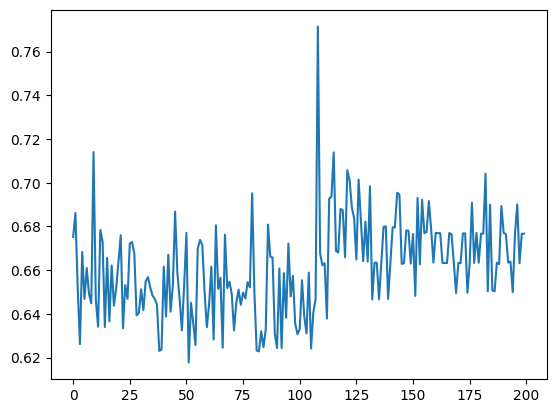

Train Accuracies


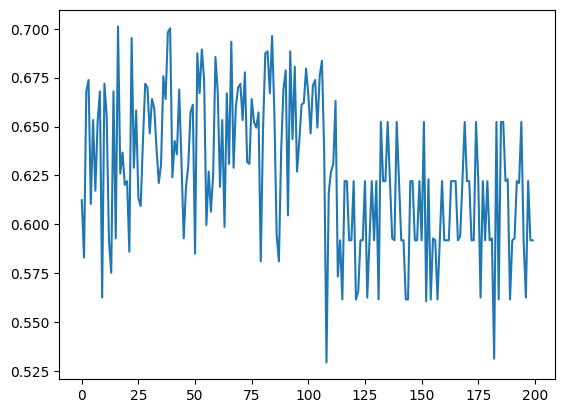

Validation Losses


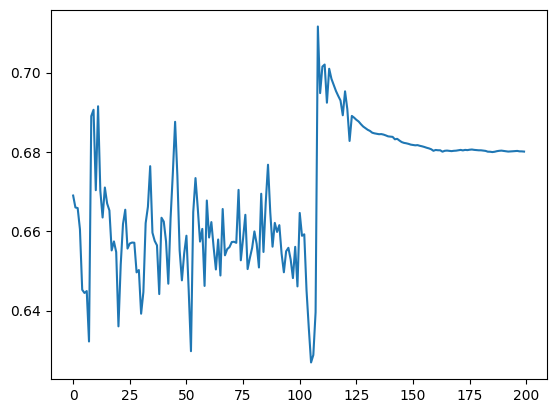

Validation Accuracies


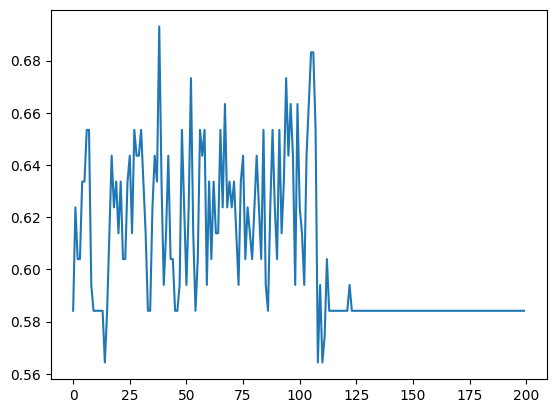

In [8]:
print("Train Losses")
plt.plot(train_losses)
plt.show()
print("Train Accuracies")
plt.plot(train_accuracies)
plt.show()
print("Validation Losses")
plt.plot(val_losses)
plt.show()
print("Validation Accuracies")
plt.plot(val_accuracies)
plt.show()

## Performance on the test set

In [9]:
seed_everything(77)
model.eval()
test_loss = 0.0
test_acc=0.0
for i, data in enumerate(tqdm(test_loader)):
        data = data.to(device)
        pred = model(data.x, data.edge_index, data.batch)
        loss = criterion(pred.squeeze(), data.y.type(torch.float))
        probs=sigmoid(pred.squeeze())
        acc=accuracy_score(data.y.cpu(),torch.round(probs).detach().cpu())
        test_acc+=acc
        test_loss += loss.item()

epoch_test_loss=test_loss/len(test_loader) # Average test loss
epoch_test_accuracy=test_acc/len(test_loader) #Average test accuracy
print(f"Test loss epoch {epoch}: ", epoch_test_loss)
print(f"Test accuracy epoch {epoch}: ", epoch_test_accuracy)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.25it/s]

Test loss epoch 199:  0.7013303637504578
Test accuracy epoch 199:  0.5357142857142857


## Further Results

We again remind that to have a complete map of all our tests, please look at _experiments.pdf_ in this repository.